## Alignment Statistics and Deletion Simulation with pysam

In [2]:
import pysam
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import Counter
from genepeeks.common import utilities as util

%matplotlib inline

In [3]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200, include_index=True)
exon_labels = ['Ex' + exon['index'] for exon in DMD_exons_merged]

Finished loading ensembl within the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 0.45 sec


In [4]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference)
# IMPORTANT: any future simulations should be created with the coordinates taken from mongo
EXON46 = [31950197, 31950344]
EXON47 = [31947713, 31947862]
EXON48 = [31893308, 31893490]
EXON49 = [31854835, 31854939]
EXON50 = [31838092, 31838200]
EXON51 = [31792077, 31792309]
DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
# curious about size of first exon which appears to be quite large
print exon_dict['1'][1] - exon_dict['1'][0]

2702


In [5]:
# Velina's local bam files for testing (names are consistent with subject/sample names)
bamfiles = ['FGPC-0000-444F.bam', 'FGPC-8V7M-82J3.bam', 'FPWB-0000-840T.bam', 'MGPC-6KHG-N0LS.bam']

In [6]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Some exploration with exon length/coordinates

Exon 1 Coordinates: [31137345, 31140047]


(<matplotlib.text.Text at 0x112f55110>, <matplotlib.text.Text at 0x112f69f90>)

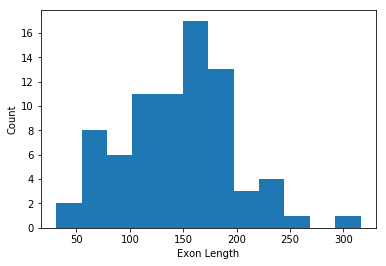

In [7]:
exon_lengths = [coord[1] - coord[0] for exon, coord in exon_dict.items() if exon != '1']
print 'Exon 1 Coordinates: {}'.format(exon_dict['1'])
plt.figure()
plt.hist(exon_lengths, bins=12)
plt.xlabel('Exon Length'), plt.ylabel('Count')

## Playing around with pysam and samtools

In [8]:
bamfile = pysam.AlignmentFile('../bams/FGPC-0000-444F.bam', 'rb')
print bamfile.references

('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT')


In [9]:
# header breakdown
print bamfile.header.keys()
# take template header from existing bamfile
template_header = bamfile.header
template_header['RG']

['SQ', 'RG', 'PG', 'HD']


[{'ID': 'FGPC-0000-444F_1-M1-1_H5FGFAFXX-L004',
  'LB': 'FGPC-0000-444F_1-M1',
  'PL': 'ILLUMINA',
  'PU': 'H5FGFAFXX-L004',
  'SM': 'FGPC-0000-444F'},
 {'ID': 'FGPC-0000-444F_1-M1-1_H5FGFAFXX-L003',
  'LB': 'FGPC-0000-444F_1-M1',
  'PL': 'ILLUMINA',
  'PU': 'H5FGFAFXX-L003',
  'SM': 'FGPC-0000-444F'},
 {'ID': 'FGPC-0000-444F_1-M1-1_H5FGFAFXX-L002',
  'LB': 'FGPC-0000-444F_1-M1',
  'PL': 'ILLUMINA',
  'PU': 'H5FGFAFXX-L002',
  'SM': 'FGPC-0000-444F'},
 {'ID': 'FGPC-0000-444F_1-M1-1_H5FGFAFXX-L001',
  'LB': 'FGPC-0000-444F_1-M1',
  'PL': 'ILLUMINA',
  'PU': 'H5FGFAFXX-L001',
  'SM': 'FGPC-0000-444F'}]

In [10]:
# does not output in same format as actual samfile -- see documentation for breakdown
iterable = bamfile.fetch('X', *EXON49)
example_read = iterable.next()
print example_read

NS500214:178:H5FGFAFXX:1:11101:1977:9301	147	22	31854685	60	151M	22	31854633	151	AAGCTTTGCCTCTTCTATTACAGTATGGCCAGTATTTCCTTACAAGTTATTTCACTGATTATAAATAGTCCACGTCAATGGCAAATGTACAACAGGGGAAGCATAACCCATTATGAGGTAATGGATATTGCTAGAGGTTGCTTCATTACCT	array('B', [12, 23, 18, 28, 27, 28, 25, 27, 29, 12, 26, 29, 29, 10, 33, 24, 29, 29, 27, 28, 30, 31, 26, 27, 29, 25, 9, 31, 32, 13, 32, 31, 27, 29, 24, 29, 28, 32, 33, 24, 27, 26, 34, 30, 32, 31, 29, 27, 29, 29, 29, 28, 34, 28, 33, 10, 29, 30, 30, 23, 30, 23, 31, 31, 30, 28, 33, 25, 29, 33, 35, 29, 28, 33, 29, 29, 31, 30, 31, 31, 32, 35, 31, 31, 30, 30, 33, 28, 29, 35, 31, 29, 35, 33, 31, 32, 25, 35, 32, 34, 33, 36, 31, 23, 32, 30, 34, 34, 36, 31, 31, 23, 31, 31, 35, 34, 32, 33, 29, 32, 31, 31, 32, 35, 31, 29, 31, 24, 31, 33, 35, 29, 34, 35, 34, 32, 33, 31, 31, 33, 35, 31, 30, 36, 31, 31, 28, 30, 29, 31, 29])	[('BD', 'KMNLCKONPONMMNNLLKMLMMMKNMMLMMMMKKBLMNLJMLLKMKJKKBLNMMNLNKIJKJDKJKMMLLLLKMMKJMLLLKCJMJLLKKJKLLIILKJLLMJIJKHLMJIJMLKLKMJJNMMNKKKJNNMLLLNMLKPPNN

In [11]:
# keep track of qnames, match between read pairs since they are consistent
# illustrate how to find mate
example_read_mate = bamfile.mate(example_read)
print example_read_mate
print example_read_mate.is_read1
example_read_mate.qname == example_read.qname

NS500214:178:H5FGFAFXX:1:11101:1977:9301	99	22	31854633	60	151M	22	31854685	151	GTTAATAGCCTTAAGATCACAATATATAAATAGGATATGCTGATCAAAAAGACAGCTTTGCCTCTGCTATTACAGTATGGCCAGTATTTCCTTACAAGTTATTTCACTGATTATAAATAGTCCACGTCAATGGCAAATGTACAACAGGGGA	array('B', [27, 28, 28, 26, 27, 31, 29, 35, 32, 32, 34, 32, 28, 30, 35, 30, 31, 35, 31, 33, 31, 31, 31, 29, 31, 29, 31, 24, 31, 31, 31, 23, 35, 34, 30, 31, 29, 31, 36, 25, 34, 36, 30, 31, 35, 31, 31, 31, 30, 31, 35, 29, 32, 31, 34, 32, 34, 32, 32, 36, 33, 32, 34, 35, 31, 36, 33, 33, 28, 30, 32, 28, 33, 31, 34, 29, 28, 30, 35, 13, 20, 9, 30, 34, 29, 28, 30, 31, 31, 34, 9, 31, 31, 28, 32, 30, 30, 33, 28, 31, 28, 30, 31, 31, 34, 30, 31, 32, 25, 25, 30, 31, 18, 26, 25, 30, 30, 23, 28, 29, 29, 30, 9, 26, 17, 24, 28, 31, 29, 11, 23, 26, 19, 17, 26, 26, 29, 29, 34, 28, 27, 23, 26, 26, 18, 25, 28, 14, 24, 23, 21])	[('BD', 'KKKJMNNPQOOMLLMNNOMLKJKKKJJJIAJJLMLLJJMLLLMLMLIAAAKLMJMMLJCKLLLKKLLLKJJILJMMLJMLKLLMMLJJCKLLKJMJJLNKJKKDLMLMMNMKJKKJBKKMNNMMLLMNMJKNMMOKCLOMNOMLM

True

In [12]:
example_read.get_tags()

[('BD',
  'KMNLCKONPONMMNNLLKMLMMMKNMMLMMMMKKBLMNLJMLLKMKJKKBLNMMNLNKIJKJDKJKMMLLLLKMMKJMLLLKCJMJLLKKJKLLIILKJLLMJIJKHLMJIJMLKLKMJJNMMNKKKJNNMLLLNMLKPPNNQQNMPLNKK'),
 ('MD', '0C12G137'),
 ('BI',
  'OQPODKOQQQQQQQQPPOQPRQPPRRQRQRQPPOGPRPONPOOOQMOOOGOQPQPPQONOOOHNOOPPQPPQOPQONQQPQOHNQNOPOONOQQMNPOOQPQOOMOLPQONNQPMQNOONQQPQOOOMPPPOOMQPNNQRQQSSQQSPPNN'),
 ('NM', 2),
 ('AS', 145),
 ('XS', 0),
 ('RG', 'FGPC-0000-444F_1-M1-1_H5FGFAFXX-L001')]

In [13]:
print example_read.reference_start
print EXON49[0]

31854685
31854835


In [14]:
coverage = bamfile.count_coverage('X', *EXON49)

In [15]:
print len(coverage[0])
print coverage[0]

104
array('L', [0L, 0L, 1L, 260L, 1L, 0L, 0L, 0L, 0L, 0L, 0L, 281L, 0L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 2L, 0L, 0L, 0L, 0L, 299L, 0L, 287L, 284L, 285L, 1L, 0L, 1L, 0L, 0L, 2L, 0L, 0L, 0L, 1L, 0L, 319L, 0L, 308L, 1L, 315L, 323L, 307L, 305L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 2L, 301L, 1L, 303L, 0L, 0L, 1L, 1L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 339L, 0L, 0L, 0L, 0L, 0L, 326L, 303L, 0L, 1L, 0L, 0L, 0L, 289L, 0L, 0L, 0L, 0L, 307L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L])


In [16]:
# getting reference name
bamfile.getrname(example_read.reference_id)

'X'

In [17]:
%%time
# next two cells testing pysam's samtools integration (specifically samtools view and merge)
infile = '../bams/FGPC-8V7M-82J3.bam'
outfile = '../bams/FGPC-8V7M-82J3_ch22.bam'
pysam.view('-b', '-o' + outfile, infile, '21', '22', catch_stdout=False)
pysam.index(outfile)

CPU times: user 7.78 s, sys: 152 ms, total: 7.93 s
Wall time: 8.02 s


In [18]:
%%time
infile = '../bams/FGPC-8V7M-82J3.bam'
outfile = '../bams/FGPC-8V7M-82J3_ch20.bam'
pysam.view('-b', '-o' + outfile, infile, '20', catch_stdout=False)
# pysam.index(outfile)

pysam.merge('-f', '../bams/combined.bam', outfile, '../bams/FGPC-8V7M-82J3_ch22.bam', catch_stdout=False)

CPU times: user 16.3 s, sys: 258 ms, total: 16.6 s
Wall time: 16.8 s


## Recording Alignment Statistics and Insert Lengths

Low mapping quality could indicate both external homology and self-similarity in the DMD gene, which could complicate techniques based on read coverage.

In [19]:
def alignment_stats(bamfile_name, reference, region, minmapQ=30):
    '''Prints alignment stats across reads in particular region in BAM. 
       reference -- ref or chrm number
       region -- list or tuple with region bounds
    '''
    with pysam.AlignmentFile(bamfile_name, 'rb') as bamfile:
        stats = Counter()
        print '{} \nChromosome {} Region {} Stats:'.format(bamfile_name, reference, region)
        for read in bamfile.fetch(reference, *region):
            stats['total'] += 1
            stats['qcfail'] += int(read.is_qcfail)

            stats['paired'] += int(read.is_paired)
            stats['read1'] += int(read.is_read1)
            stats['read2'] += int(read.is_read2)
            
            if read.is_unmapped:
                stats['unmapped'] += 1
                continue

            stats['mapq <= 30'] += int(read.mapping_quality <= minmapQ)

            stats['mapped'] += 1
            if read.is_proper_pair:
                stats['proper pair'] += 1
                if abs(read.template_length) > 850:
                    stats['long_insert'] += 1
                    print '\tlong insert/error: {}'.format(read.template_length)
                else:
                    stats['insert_lengths'] += (abs(read.template_length) if read.is_read1 else 0)

        stats['avg insert length'] = stats['insert_lengths'] / float(stats['read1'])
        output_order = ('total', 'mapped', 'unmapped', 'paired', 'read1', 'read2', 
                        'proper pair', 'qcfail', 'mapq <= 30', 'long_insert', 'avg insert length')

        for key in output_order:
            if key == 'avg insert length':
                print '\t{}: {}'.format(key, stats[key])
            else:
                print '\t{}: {}, Prop: {}'.format(key, stats[key], stats[key] / float(stats['total']))

In [20]:
alignment_stats('../bams/FGPC-0000-444F.bam', 'X', EXON49)

../bams/FGPC-0000-444F.bam 
Chromosome X Region [31854835, 31854939] Stats:
	total: 680, Prop: 1.0
	mapped: 680, Prop: 1.0
	unmapped: 0, Prop: 0.0
	paired: 680, Prop: 1.0
	read1: 342, Prop: 0.502941176471
	read2: 338, Prop: 0.497058823529
	proper pair: 680, Prop: 1.0
	qcfail: 0, Prop: 0.0
	mapq <= 30: 0, Prop: 0.0
	long_insert: 0, Prop: 0.0
	avg insert length: 226.011695906


In [21]:
for bam in bamfiles:
    alignment_stats('../bams/{}'.format(bam), 'X', DMD)

../bams/FGPC-0000-444F.bam 
Chromosome X Region [31115794, 33357558] Stats:
	long insert/error: 87733677
	long insert/error: 36406070
	long insert/error: 67357711
	total: 88693, Prop: 1.0
	mapped: 88577, Prop: 0.998692117755
	unmapped: 116, Prop: 0.0013078822455
	paired: 88693, Prop: 1.0
	read1: 44343, Prop: 0.499960538036
	read2: 44350, Prop: 0.500039461964
	proper pair: 88301, Prop: 0.995580259998
	qcfail: 0, Prop: 0.0
	mapq <= 30: 180, Prop: 0.00202947244991
	long_insert: 3, Prop: 3.38245408319e-05
	avg insert length: 246.341519518
../bams/FGPC-8V7M-82J3.bam 
Chromosome X Region [31115794, 33357558] Stats:
	long insert/error: 8528942
	long insert/error: -3886263
	total: 19239, Prop: 1.0
	mapped: 19235, Prop: 0.999792088986
	unmapped: 4, Prop: 0.000207911014086
	paired: 19239, Prop: 1.0
	read1: 9621, Prop: 0.50007796663
	read2: 9618, Prop: 0.49992203337
	proper pair: 19209, Prop: 0.998440667394
	qcfail: 0, Prop: 0.0
	mapq <= 30: 29, Prop: 0.00150735485212
	long_insert: 2, Prop: 0.000

### Conclusions
Mapping quality seems to be fairly high across DMD gene (only 0.1-0.4% of reads have mapQ less than 30) for 4 samples tested here. 

Repeat with more samples -- could also check specific regions, add check to see if reads with low mapQ are also short or low quality reads. 

In addition, dot plots of several different regions of the gene (region compared to itself) indicate few patterns of self-similarity within the gene.

Pixel gradient is based on proportion of matching bases with window size 25. No gradation below 20% homology. See plot titles for region coordinates.

<img src="images/region1_dot.png" width="500">
<img src="images/region2_dot.png" width="500">
<img src="images/region3_dot.png" width="500">

## Writing basic BAMs with simulated deletions and duplications

In [22]:
def simulate_exon_CNV(outfile, infile_bam, chrom_ref, mut_region, CNV_type='deletion', region_buffer=0, mult_factor=0.5, 
                      output_full=False, before_wanted=None, after_wanted=None):
    ''' Simulates deletion in specified region by reducing the number of aligned reads in region 
        by specified depletion_factor. Assumes bam file is sorted.
        chrom_ref -- '1', 'X', etc
        mut_region -- two element list with region limits for region to be deleted/duplicated, eg. [34000000, 34560000]
        CNV_type -- 'deletion' or 'duplication'
        region_buffer -- number of bp by which to extend region on either end (reads often extend past exons)
        mult_factor -- float indicating factor to multiply by read count (should be > 1 for duplications)
        output_full -- option to generate complete bam file (all chromosomes) vs bam file with just chrom_ref
    '''
    if mut_region[0] > mut_region[1]:
        raise ValueError('Region boundaries invalid')
    mut_region = [mut_region[0] - region_buffer, mut_region[1] + region_buffer]
        
    template_bam = pysam.AlignmentFile(infile_bam, 'rb')
    template_header = template_bam.header
    for RG in template_header['RG']:
        RG['SM'] = '{}_{}'.format(RG['SM'], ('del' if CNV_type == 'deletion' else 'dup'))
    
    with pysam.AlignmentFile(outfile, 'wb', header=template_header) as outf:
        keep_reads = []
        total_reads = []
        started_mut = False
        finished_mut = False
        for read in template_bam.fetch(chrom_ref):
            if (
                (read.reference_end >= mut_region[0] or started_mut) and 
                read.reference_start <= mut_region[1]
               ):
                if not started_mut:
                    started_mut = True
                if read.is_paired and read.is_read1:
                    if random.random() < (mult_factor if CNV_type == 'deletion' else mult_factor - 1.0):
                        keep_reads.append(read.qname)
                total_reads.append(read)
                    
            elif read.reference_start > mut_region[1]:
                if finished_mut:
                    outf.write(read)
                else:
                    print 'Writing to outfile from mutation region'
                    for saved_read in total_reads:
                        if CNV_type == 'duplication':
                            outf.write(saved_read)
                        if saved_read.qname in keep_reads:
                            outf.write(saved_read)
                    finished_mut = True
                    outf.write(read)
            else:
                outf.write(read)
        total_mate_names = [read.qname for read in total_reads if read.is_read2]
        distant_mates = [name for name in keep_reads if name not in total_mate_names]
        print 'Finished generating reads in bamfile for desired chrom_ref'
        print 'Number of distant mates: {}'.format(len(distant_mates))
        print 'Total number of mates to keep: {}'.format(len(keep_reads))
    
    # generates bam file for all chroms before desired and separate bam file for all chroms after; 
    # then merges three bam files -- might require clean up of extra files after running
    if output_full:
        ref_list = list(template_bam.references)
        index = ref_list.index(chrom_ref)
        
        if not before_wanted:   
            before = ref_list[:index]
            before_wanted = '{}_before_{}.bam'.format(os.path.splitext(infile_bam)[0], chrom_ref)
            pysam.view('-b', '-o' + before_wanted, infile_bam, *before, catch_stdout=False)
            print 'Finished generating bamfile for refs before chrom_ref'
            
        if not after_wanted:
            after = ref_list[(index + 1):]
            after_wanted = '{}_after_{}.bam'.format(os.path.splitext(infile_bam)[0], chrom_ref)
            pysam.view('-b', '-o' + after_wanted, infile_bam, *after, catch_stdout=False)
            print 'Finished generating bamfile for refs after chrom_ref'

        outfile_full = '{}_full.bam'.format(os.path.splitext(outfile)[0])
        pysam.merge('-f', outfile_full, before_wanted, outfile, after_wanted, catch_stdout=False)
        print 'Finished merging all bamfiles into final output'
        
        template_bam.close()
        pysam.index(outfile_full)
    else:
        pysam.index(outfile)
        
    print 'Finished creating index file for final output bamfile'

In [23]:
%%time
# assuming bams live in bams directory
outfile = '../bams/FGPC-0000-444F_49_del.bam'
simulate_exon_CNV(outfile, '../bams/FGPC-0000-444F.bam', 'X', exon_dict['49'], mult_factor=0.5)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 75
Total number of mates to keep: 353
Finished creating index file for final output bamfile
CPU times: user 1min 10s, sys: 1.37 s, total: 1min 11s
Wall time: 1min 12s


In [24]:
%%time
# testing deletion
# assuming bams live in bams directory -- this time with ensembl exon def
outfile = '../bams/FGPC-0000-444F_30_delPEM.bam'
simulate_exon_CNV(outfile, '../bams/FGPC-0000-444F.bam', 'X', exon_dict['30'], mult_factor=0.5)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 33
Total number of mates to keep: 137
Finished creating index file for final output bamfile
CPU times: user 1min 7s, sys: 1.04 s, total: 1min 8s
Wall time: 1min 9s


In [25]:
%%time
# testing duplication
# assuming bams live in bams directory -- this time with ensembl exon def
outfile = '../bams/FGPC-0000-444F_30_dupPEM.bam'
simulate_exon_CNV(outfile, '../bams/FGPC-0000-444F.bam', 'X', exon_dict['30'], CNV_type='duplication', mult_factor=1.5)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 32
Total number of mates to keep: 135
Finished creating index file for final output bamfile
CPU times: user 1min 7s, sys: 1.07 s, total: 1min 8s
Wall time: 1min 9s


In [26]:
%%time
# another deletion
# assuming bams live in bams directory -- this time with ensembl exon def
outfile = '../bams/FPWB-0000-840T_45_delPEM.bam'
simulate_exon_CNV(outfile, '../bams/FPWB-0000-840T.bam', 'X', exon_dict['45'], CNV_type='deletion', region_buffer=500,
                  mult_factor=0.5)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 58
Total number of mates to keep: 1012
Finished creating index file for final output bamfile
CPU times: user 1min 22s, sys: 1.43 s, total: 1min 24s
Wall time: 1min 24s


In [27]:
%%time
# another duplication
# assuming bams live in bams directory -- this time with ensembl exon def
outfile = '../bams/FPWB-0000-840T_19_dupPEM.bam'
simulate_exon_CNV(outfile, '../bams/FPWB-0000-840T.bam', 'X', exon_dict['19'], CNV_type='duplication', mult_factor=1.5)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 143
Total number of mates to keep: 242
Finished creating index file for final output bamfile
CPU times: user 1min 24s, sys: 1.47 s, total: 1min 26s
Wall time: 1min 26s


### Testing output of full bamfile (including other chromosomes) 
Note that these cells will run quite slowly.

In [28]:
%%time
# this is a relatively small bamfile (only about 1.5 GB) -- outputting full bamfile is quite slow in general
infile = '../bams/FGPC-8V7M-82J3.bam'
outfile = '../bams/FGPC-8V7M-82J3_48-50_del0.35.bam'
simulate_exon_CNV(outfile, infile, 'X', EX48_50_PART, mult_factor=0.35, output_full=True)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 0
Total number of mates to keep: 61
Finished generating bamfile for refs before chrom_ref
Finished generating bamfile for refs after chrom_ref
Finished merging all bamfiles into final output
Finished creating index file for final output bamfile
CPU times: user 9min 20s, sys: 18 s, total: 9min 38s
Wall time: 9min 50s


In [29]:
%%time
infile = '../bams/FGPC-8V7M-82J3.bam'
outfile = '../bams/FGPC-8V7M-82J3_48-50_del.bam'
before_wanted = '../bams/FGPC-8V7M-82J3_before_X.bam'
after_wanted = '../bams/FGPC-8V7M-82J3_after_X.bam'
simulate_exon_CNV(outfile, infile, 'X', EX48_50_PART, mult_factor=0.5, output_full=True, 
                  before_wanted=before_wanted, after_wanted=after_wanted)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 0
Total number of mates to keep: 103
Finished merging all bamfiles into final output
Finished creating index file for final output bamfile
CPU times: user 5min 11s, sys: 10.3 s, total: 5min 21s
Wall time: 5min 27s


### Generating deletion of exons 48-50

In [30]:
%%time
ex48_50 = [exon_dict['48'][0], exon_dict['50'][1]]
outfile = '../bams/FPWB-0000-822R_4850_delPEM.bam'
simulate_exon_CNV(outfile, '../bams/FPWB-0000-822R.bam', 'X', ex48_50, CNV_type='deletion', mult_factor=0.5)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 94
Total number of mates to keep: 958
Finished creating index file for final output bamfile
CPU times: user 1min 30s, sys: 3.34 s, total: 1min 33s
Wall time: 1min 35s


### Generating deletion of exons 16-19

In [31]:
%%time
# note slightly higher mult_factor here
ex16_19 = [exon_dict['16'][0], exon_dict['19'][1]]
outfile = '../bams/FGPC-4ZPF-J0F1_1619_delPEM.bam'
simulate_exon_CNV(outfile, '../bams/FGPC-4ZPF-J0F1.bam', 'X', ex16_19, CNV_type='deletion', mult_factor=0.65)

Writing to outfile from mutation region
Finished generating reads in bamfile for desired chrom_ref
Number of distant mates: 62
Total number of mates to keep: 868
Finished creating index file for final output bamfile
CPU times: user 47 s, sys: 1.91 s, total: 48.9 s
Wall time: 50.2 s
